In [1]:
#Importamos las librerias necesarias
import re
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import gurobipy as grb
from gurobipy import GRB
from timeit import timeit
from time import time

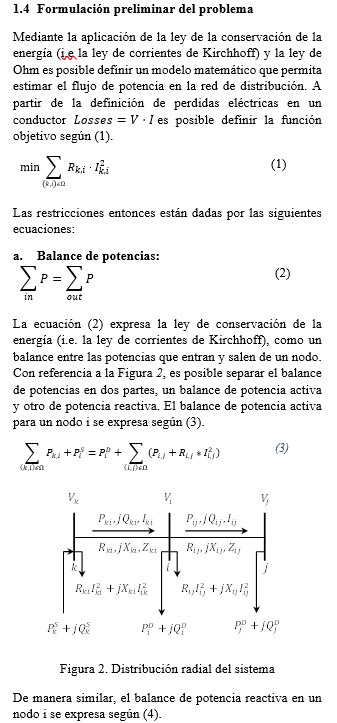

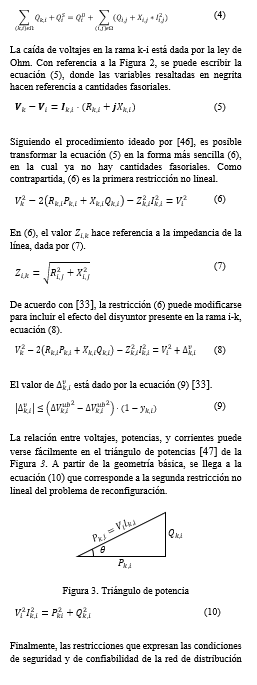

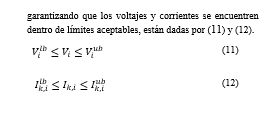

In [3]:
#Vamos creando aqui la clase
class DistributionNetwork():
    def __init__(self,ruta,b):
        self.b=b#parametro de tunning restriccion cespedes.
        self.ruta=ruta
        file=open(self.ruta)#abre el archivo
        datos=file.readlines()#lee el contenido del archivo
        file.close()#cierra el archivo
        #Ahora determinamos los inicios y finales de las tablas de ramas y potencias:
        #primero declaramos algunas variables utiles:
        nodo_ref=0
        index_inicio_ramas=0
        index_final_ramas=0
        index_inicio_potencias=0
        index_final_potencias=0
        datos_ramas=[]
        datos_potencias=[]
        
        #determinamos el inicio y final de la tabla de ramas:
        for index, line in enumerate(datos):#Hallamos el inicio y el final de la tabla de datos de la red
            if line.startswith("ramos = ["):
                index_inicio_ramas=index
                print(index_inicio_ramas)
            if line.endswith("];\n"):
                index_final_ramas=index
                print(index_final_ramas)
                break
        #determinamos el inicio y final de la tabla de potencias:
        for index, line in enumerate(datos):#Hallamos el inicio y el final de la tabla de datos de potencia
            if line.startswith("barras"):
                index_inicio_potencias=index
                print(index_inicio_potencias)
            if (line.endswith("];\n")| line.endswith("];")) and index_inicio_potencias!=0:
                index_final_potencias=index
                print(index_final_potencias)
                break
        print(index_inicio_ramas)
        #Ahora si, extraemos todos los datos necesarios del archivo:
        for index, line in enumerate(datos):#itera sobre cada una de las lineas de datos
            if line.startswith("""% Datos globales"""):
                self.nodo_ref=int(re.findall('\d{1,3}',datos[index+1])[0])#almacena el atributo nodo de referencia
                self.v_ref=float(re.findall('\d{1,2}\.\d{1,2}',datos[index+2])[0])#almacena el atributo voltaje de referencia
                self.v_base=float(re.findall('\d{1,2}\.\d{1,2}',datos[index+3])[0])*1000#almacena el atributo voltaje base
                self.s_base=float(re.findall('\d+',datos[index+4])[0])*1000#almacena el atributo potencia aparente base
                self.tol=float(re.findall('\d{1,2}\^\-\d{1}',
                                          datos[index+5])[0][0:2])**float(re.findall('\d{1,2}\^\-\d{1}',
                                                                                    datos[index+5])[0][3:5])#almacena el atributo tolerancia
                #self.v_min=float(re.findall('\d{1,2}\.\d{1,2}',datos[index+6])[0])#almacena el atributo voltaje minimo
                self.v_min=0
                
                #self.v_max=float(re.findall('\d{1,2}\.\d{1,2}',datos[index+7])[0])#almacena el atributo voltaje_maximo
                self.v_max=1
                #self.v_max=1.5
                self.z_base=self.v_base**2/self.s_base#calcula la impedancia base a partir de la ley de ohm
                self.i_max=5
                #extraemos los datos de las ramas:
            if index>=index_inicio_ramas and index<=index_final_ramas:#extraemos los datos de las ramas
                nodos=re.findall("\d{1,3}",line)
                impedancia=re.findall("\d{1,3}\.\d{1,7}",line)
                datos_ramas.append([nodos[0],nodos[1],impedancia[0],impedancia[1]])
            #extrae los datos de las potencias
            if index>=index_inicio_potencias and index<=index_final_potencias:
                lista_re=re.findall("\d+\.*\d*",line)
                datos_potencias.append([lista_re[0],lista_re[1],lista_re[2],lista_re[3]])
            #creamos dos dataframes:
            #print(datos_ramas)
            self.ramas=pd.DataFrame(datos_ramas,columns=["nodo_i","nodo_j","R","X"])#creamos los dataframes de ramas y potencias
            self.potencias=pd.DataFrame(datos_potencias,columns=["nodo","Pd","Qd","Qbc"])
            #Ajustamos el tipo de dato de todas las columnas a ser float64
            self.potencias.nodo=self.potencias.nodo.astype("float")
            self.potencias.Pd=self.potencias.Pd.astype("float")*1000
            self.potencias.Qd=self.potencias.Qd.astype("float")*1000
            self.potencias.Qbc=self.potencias.Qbc.astype("float")*1000
            self.ramas.nodo_i= self.ramas.nodo_i.astype("float")
            self.ramas.nodo_j= self.ramas.nodo_j.astype("float")
            self.ramas.R= self.ramas.R.astype("float")
            self.ramas.X= self.ramas.X.astype("float")
            
            #Generamos a continuacion la red
        self.generar_red()
        #Generamos el modelo de gurobi
        self.generar_modelo_base()
        self.generar_variables_disyuntores()#Generemos la variable y_ij asociada al estado de los disyuntores
        self.generar_variables_potencia_ij()#Generamos la variable P_ij, asociada a la potencia activa de i a j
        self.generar_variable_Q_ij()#Generamos la variable Q_ij asociada a la potencia reactiva de i a j
        #self.generar_variables_V_i()#Generamos la vairable V_i, asociada al voltaje del nodo i
        self.generar_variables_Vsqr_i()#Generamos la variable Vsqr, asociada al cuadrado del voltaje del nodo i
        #self.generar_variables_I_ij()#Generamos la variable I_ij, asociada a la corriente del arco i,j
        self.generar_variables_I_sqr()#Genermos la variable I_ij_sqr asociada al cuadrado de la corriente del arco ij
        self.generar_variable_delta_ij()
        #A continuación generamos las restricciones del problema
        self.generar_restriccion_corrientes_sqr()
        self.generar_restriccion_un_solo_arco_ij()
        self.generar_restriccion_triangulo_potencia()
        self.generar_restriccion_delta()
        self.generar_restriccion_Ohm()
        self.balance_reactiva()
        self.balance_activa()
        #self.modelo.addConstr(self.voltajes_sqr[14]==1)#Fijamos el voltaje de la subestacion en 1 p.u
        #self.restriccion_auxiliar()
        #Actualizar el modelo
        self.modelo.update()
        #Escribir el reporte del modelo
        self.generar_reporte()
        #Optimizar
        #self.optimizar()
    def generar_red(self):
        #En esta seccion generamos la red:
        self.Red=nx.DiGraph()#Creamos un elemento digraph
        #Recorremos primero la tabla de ramas:
        for element in self.ramas.itertuples():
            self.Red.add_edge(element[1],element[2])#añade el arco de i a j
            self.Red.add_edge(element[2],element[1])#añade el arco de j a i
            #Ahora añadimos la resistencia y la impedancia
            self.Red.edges[element[1],element[2]]["R"]=element[3]/self.z_base#Añadimos la resistencia al arco ij
            self.Red.edges[element[1],element[2]]["X"]=element[4]/self.z_base#Añadimos la inductancia al arco ij
            self.Red.edges[element[2],element[1]]["R"]=element[3]/self.z_base#Añadimos la resistencia al arco ij
            self.Red.edges[element[2],element[1]]["X"]=element[4]/self.z_base#Añadimos la inductancia al arco ij
        #Ahora recorremos la tabla de potencias
        for element in self.potencias.itertuples():
            self.Red.nodes[element[1]]["Pd"]=element[2]/self.s_base#Añadimos la demanda de potencia activa en el nodo
            self.Red.nodes[element[1]]["Qd"]=element[3]/self.s_base#Añadimos la demanda de potencia reactiva en el nodo
            self.Red.nodes[element[1]]["Qbc"]=element[4]/self.s_base#Añadimos el Qbc del nodo
    def graficar_red(self):
        nx.draw(self.Red, pos=nx.kamada_kawai_layout(self.Red),with_labels=True)
        plt.show()
    def generar_modelo_base(self):
        #Se crea un objeto modelo de gurobipy
        self.modelo=grb.Model(self.ruta[0:-4])
    def generar_variables_disyuntores(self):
        #En esta parte creamos la variable disyuntores 
        self.y=self.modelo.addVars(list(self.Red.edges),vtype=GRB.BINARY, name="estado_disyuntor",ub=1)
    def generar_variables_potencia_ij(self):
        self.pot=self.modelo.addVars(list(self.Red.edges),vtype=GRB.CONTINUOUS, name="potencia_activa",lb=0,ub=5)
    def generar_variable_Q_ij(self):
        self.q=self.modelo.addVars(list(self.Red.edges),vtype=GRB.CONTINUOUS, name="potencia_reactiva",lb=0,ub=5)
    def generar_variables_V_i(self):
        self.voltajes=self.modelo.addVars(list(self.Red.nodes),vtype=GRB.CONTINUOUS, name="voltaje",ub=self.v_max*self.v_base,
                                         lb=self.v_min*self.v_base)
    def generar_variables_Vsqr_i(self):
        self.voltajes_sqr=self.modelo.addVars(list(self.Red.nodes),vtype=GRB.CONTINUOUS, name="voltaje_sqr",
                                              lb=(self.v_min)**2,
                                              
                                              ub=(self.v_max)**2)
    def generar_variables_I_ij(self):
        self.corrientes=self.modelo.addVars(list(self.Red.edges),vtype=GRB.CONTINUOUS, name="corriente",ub=self.i_max)
    def generar_variables_I_sqr(self):
        lista_resistencias=[element[2]["R"] for element in self.Red.edges.data()]#Generamos una lista con las resistencias de los arcos
        self.corrientes_sqr=self.modelo.addVars(list(self.Red.edges),vtype=GRB.CONTINUOUS, name="corriente_sqr",
                                                obj=lista_resistencias,lb=0,ub=self.i_max**2)
    def generar_variable_delta_ij(self):
        b_abs=abs(self.v_max-self.v_min)
        self.delta=self.modelo.addVars(list(self.Red.edges),vtype=GRB.CONTINUOUS,name="delta",lb=-b_abs,ub=b_abs)
    def generar_reporte(self):
        self.modelo.write("reporte.lp")
        print("model written!!")
    def generar_restriccion_corrientes_sqr(self):
        #Esta función genera la restricción I_sqr<=I_ij**2
        for row in self.ramas.itertuples():#iteramos sobre el dataframe de ramas
            nodo_i=row[1]
            nodo_j=row[2]
            self.modelo.addConstr(self.corrientes_sqr[(nodo_i,nodo_j)]<=self.y[(nodo_i,nodo_j)]*self.i_max**2)#Restriccion del
            #arco ij
            self.modelo.addConstr(self.corrientes_sqr[(nodo_j,nodo_i)]<=self.y[(nodo_j,nodo_i)]*self.i_max**2)#Restriccion del
            #arco ij
    def generar_restriccion_un_solo_arco_ij(self):
        #Esta funcion genera la restriccion y_ij+y_ji=1
      
        #self.modelo.addConstr(grb.quicksum(self.y[edge] for edge in self.Red.edges())==len(self.Red.nodes())-1)
        for nodo in self.Red.nodes:
            
            if nodo!=self.nodo_ref:
                
                self.modelo.addConstr(self.y.sum('*',nodo)==1)
               
            else:
                self.modelo.addConstr(self.y.sum(nodo,'*')>=1)
        for element in self.ramas.itertuples():
            nodo_i=element[1]
            nodo_j=element[2]
            self.modelo.addConstr(self.y[(nodo_i,nodo_j)]+self.y[(nodo_j,nodo_i)]<=1)
        
        
            
    def generar_restriccion_triangulo_potencia(self):#Genera la restriccion P**2+Q**2=S**2
        for edge in self.Red.edges():
            nodo_j=edge[1]
            self.modelo.addConstr(self.corrientes_sqr[edge]>=(self.pot[edge])**2+(self.q[edge])**2)
    def generar_restriccion_delta(self):
        for edge in self.Red.edges():
            self.modelo.addConstr(self.b*(1-self.y[edge])>=self.delta[edge])#b*(1-y_ij)>=delta_ij
            self.modelo.addConstr(-self.b*(1-self.y[edge])<=self.delta[edge])#delta_ij>=-b*(1-y_ij)
    def generar_restriccion_Ohm(self):#Genera la restriccion de cespedes
        for edge in self.Red.edges():#Recorremos cada rama
            #Añadimos la restricción de cespedes
            nodo_i=edge[0]
            nodo_j=edge[1]
            R=self.Red.edges[edge]["R"]#Obtenemos la resistencia del arco ij
            X=self.Red.edges[edge]["X"]#Obtenemos la resistencia del arco ij
            Z_sqr=R**2+X**2#Clculamos la magnitud de la impedancia al cuadrado del arco ij
            self.modelo.addConstr(self.voltajes_sqr[nodo_i]==self.voltajes_sqr[nodo_j]+
                                  2*(R*self.pot[edge]+X*self.q[edge])-Z_sqr*self.corrientes_sqr[edge]+self.delta[edge])
    def balance_reactiva(self):#Genera la restriccion de balance de potencia reactiva
        for node in self.Red.nodes():#Iteramos sobre los nodos de la red
            if node!=self.nodo_ref:
                #Aplica para todos los nodos excepto el de referencia
                my_dict={(node,i):self.Red.edges[(node,i)]["X"] for i in self.Red.nodes() if (node,i) in self.Red.edges()}
                corrientes, coeff = grb.multidict(my_dict)#creamos un objeto multidict
                self.modelo.addConstr(self.q.sum('*',node)-self.q.sum(node,'*')-self.corrientes_sqr.prod(coeff,node,'*')==
                                      self.Red.nodes[node]["Qd"])#Creamos la restriccion de balance de potencia reactiva
            else:#Este caso solo aplica para los nodos subestación
                my_dict={(node,i):self.Red.edges[(node,i)]["X"] for i in self.Red.nodes() if (node,i) in self.Red.edges()}
                corrientes, coeff = grb.multidict(my_dict)#creamos un objeto multidict
                self.modelo.addConstr(self.q.sum('*',node)-self.q.sum(node,'*')-self.corrientes_sqr.prod(coeff,node,'*')<=
                                      -sum(self.potencias.Qd)/self.s_base)#Creamos la restriccion de balance de potencia reactiva
    def balance_activa(self):#Genera la restriccion de balance de potencia activa
        for node in self.Red.nodes():#Iteramos sobre los nodos de la red
            if node!=self.nodo_ref:#esta condición aplica para todos los nodos que no son subestacion
                my_dict={(node,i):self.Red.edges[(node,i)]["R"] for i in self.Red.nodes() if (node,i) in self.Red.edges()}
                corrientes, coef = grb.multidict(my_dict)#creamos un objeto multidict
                self.modelo.addConstr(self.pot.sum('*',node)-self.pot.sum(node,'*')-self.corrientes_sqr.prod(coef,node,'*')==
                                    self.Red.nodes[node]["Pd"])#Añade la restricción de flujo de activa
            else:#Este caso solo aplica para los nodos subestacion
                my_dict={(node,i):self.Red.edges[(node,i)]["R"] for i in self.Red.nodes() if (node,i) in self.Red.edges()}
                corrientes, coef = grb.multidict(my_dict)#creamos un objeto multidict
                self.modelo.addConstr(self.pot.sum('*',node)-self.pot.sum(node,'*')-self.corrientes_sqr.prod(coef,node,'*')<=
                                    -sum(self.potencias.Pd)/self.s_base)
    def restriccion_auxiliar(self):#Esta no sirvio!
        for node in self.Red.nodes():#Iteramos sobre los nodos
            if node!=self.nodo_ref:#Para todos los nodos esxcepto el de referencia
                self.modelo.addConstr(self.y.sum('*',node)==1)
                R=self.Red.predecessors(node)
                #maxVarsList=[self.y[node,element] for elemen in R]
                #self.modelo.addGenConstrMax(1, maxVarsList, name='maxconstr_')
                #"self.modelo.addConstr(1==grb.max_(self.y[element,node] for element in R))
                self.modelo.addConstr((self.y.sum('*',node))**2-2*self.y.sum('*',node)<=-1)
                #R=self.Red.predecessors(node)
                #self.modelo.addConstr(grb.quicksum(self.y[r,node]**2 for r in R)<=1)
            else:#el nodo ref
                #self.modelo.addConstr(self.y.sum(node,'*')==3)
                pass
    
    def optimizar(self):
        #self.modelo.params.NonConvex = 2
        start=time()
        self.modelo.optimize()
        self.tiempo_computo=time()-start
        if self.modelo.Status == grb.GRB.INFEASIBLE:
            self.modelo.computeIIS()
            self.modelo.write('iismodel.ilp')
    def get_red_opti(self):
        self.red_optima=nx.Graph()
        for element in self.y:
            if round(self.y[element].x)==1:
                self.red_optima.add_edge(element[0],element[1])
        nx.draw(self.red_optima, pos=nx.kamada_kawai_layout(self.red_optima),with_labels=True)
        plt.show()
   
    

                
    
                
            
       
            
    
    
        
    
        
            
            
        
            
        


In [4]:
red_84=DistributionNetwork("datos417.txt",0.2)
#red_14.v_min=0.5
#red_14.potencias

16
488
492
906
16
Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-14
model written!!


In [ ]:
red_84.modelo.optimize()

Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 5 3550H with Radeon Vega Mobile Gfx, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 5502 rows, 5145 columns and 18920 nonzeros
Model fingerprint: 0x31e05201
Model has 946 quadratic constraints
Variable types: 4199 continuous, 946 integer (946 binary)
Coefficient statistics:
  Matrix range     [2e-06, 3e+01]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e-03, 6e-01]
  Bounds range     [1e+00, 3e+01]
  RHS range        [1e-06, 1e+00]
Presolve removed 1117 rows and 896 columns
Presolve time: 0.08s
Presolved: 4385 rows, 4249 columns, 15572 nonzeros
Presolved model has 836 quadratic constraint(s)
Variable types: 3752 continuous, 497 integer (497 binary)

Root relaxation: objective 2.094891e-05, 1791 iterations, 0.07 seconds (0.05 work units)

    Nodes    |    Current Node    |     Object

 12173  5483    0.00577   29  124    0.00586    0.00474  19.1%   130  170s
H12321  5303                       0.0058484    0.00475  18.9%   129  170s
*12321  5303              95       0.0058484    0.00475  18.9%   129  170s
 12596  5624    0.00524   37  131    0.00585    0.00476  18.5%   130  177s
 13126  5919     cutoff   45         0.00585    0.00479  18.0%   130  183s
 13595  6220    0.00576   44   86    0.00585    0.00480  17.9%   130  190s
 14222  6679     cutoff   41         0.00585    0.00481  17.8%   129  197s
 14887  7098    0.00497   25  134    0.00585    0.00482  17.6%   128  204s
H15485  4843                       0.0056565    0.00482  14.8%   128  215s
H15487  4814                       0.0056552    0.00482  14.8%   128  215s
H15488  4416                       0.0056146    0.00482  14.2%   128  215s
 15493  4724    0.00550   45   72    0.00561    0.00482  14.1%   128  224s
 15983  4976    0.00559   47   81    0.00561    0.00483  13.9%   129  233s
 16415  5255    0.00510  

In [ ]:
red_optima=nx.Graph()
for element in red_84.y:
    if round( red_84.y[element].x)==1:
        
        red_optima.add_edge(element[0],element[1])
plt.figure(3,figsize=(24,24))
nx.draw(red_optima, pos=nx.kamada_kawai_layout(red_optima),with_labels=True)

plt.show()

EN este caso podemos ver que la solución a la que converge el modelo es efectivamente un arból, cuya raiz es el nodo 14, corres-
pondiente a la subestación. A continuación se muestran los valores de las diferentes variables del modelo. 

In [47]:
for v in red_84.modelo.getVars():
    if v.x>1e-6:
        print(v.varName)

estado_disyuntor[384.0,68.0]
estado_disyuntor[384.0,66.0]
estado_disyuntor[384.0,243.0]
estado_disyuntor[68.0,384.0]
estado_disyuntor[68.0,85.0]
estado_disyuntor[68.0,93.0]
estado_disyuntor[68.0,67.0]
estado_disyuntor[89.0,67.0]
estado_disyuntor[89.0,88.0]
estado_disyuntor[67.0,89.0]
estado_disyuntor[67.0,64.0]
estado_disyuntor[67.0,68.0]
estado_disyuntor[225.0,224.0]
estado_disyuntor[225.0,226.0]
estado_disyuntor[224.0,225.0]
estado_disyuntor[224.0,222.0]
estado_disyuntor[21.0,72.0]
estado_disyuntor[21.0,47.0]
estado_disyuntor[21.0,50.0]
estado_disyuntor[21.0,49.0]
estado_disyuntor[21.0,57.0]
estado_disyuntor[72.0,21.0]
estado_disyuntor[72.0,74.0]
estado_disyuntor[72.0,76.0]
estado_disyuntor[72.0,73.0]
estado_disyuntor[66.0,384.0]
estado_disyuntor[66.0,382.0]
estado_disyuntor[66.0,252.0]
estado_disyuntor[3.0,20.0]
estado_disyuntor[3.0,7.0]
estado_disyuntor[3.0,9.0]
estado_disyuntor[3.0,10.0]
estado_disyuntor[20.0,3.0]
estado_disyuntor[20.0,51.0]
estado_disyuntor[20.0,44.0]
estado_disy

voltaje_sqr[208.0]
voltaje_sqr[277.0]
voltaje_sqr[106.0]
voltaje_sqr[95.0]
voltaje_sqr[6.0]
voltaje_sqr[7.0]
voltaje_sqr[33.0]
voltaje_sqr[278.0]
voltaje_sqr[84.0]
voltaje_sqr[279.0]
voltaje_sqr[111.0]
voltaje_sqr[18.0]
voltaje_sqr[5.0]
voltaje_sqr[28.0]
voltaje_sqr[36.0]
voltaje_sqr[280.0]
voltaje_sqr[45.0]
voltaje_sqr[281.0]
voltaje_sqr[119.0]
voltaje_sqr[121.0]
voltaje_sqr[49.0]
voltaje_sqr[235.0]
voltaje_sqr[14.0]
voltaje_sqr[55.0]
voltaje_sqr[23.0]
voltaje_sqr[282.0]
voltaje_sqr[118.0]
voltaje_sqr[8.0]
voltaje_sqr[9.0]
voltaje_sqr[234.0]
voltaje_sqr[122.0]
voltaje_sqr[236.0]
voltaje_sqr[16.0]
voltaje_sqr[19.0]
voltaje_sqr[104.0]
voltaje_sqr[105.0]
voltaje_sqr[32.0]
voltaje_sqr[232.0]
voltaje_sqr[349.0]
voltaje_sqr[37.0]
voltaje_sqr[207.0]
voltaje_sqr[108.0]
voltaje_sqr[13.0]
voltaje_sqr[42.0]
voltaje_sqr[380.0]
voltaje_sqr[229.0]
voltaje_sqr[109.0]
voltaje_sqr[4.0]
voltaje_sqr[12.0]
voltaje_sqr[46.0]
voltaje_sqr[228.0]
voltaje_sqr[15.0]
voltaje_sqr[231.0]
voltaje_sqr[110.0]
voltaj

In [8]:
for element in red_84.modelo.getVars():
    if element.varName.startswith("estado_disyuntor"):
        element.setAttr(GRB.Attr.VType, GRB.BINARY)


In [38]:
red_84.modelo.update()

In [9]:
for v in red_84.modelo.getVars():
    print(v.varName,v.VType)

estado_disyuntor[384.0,68.0] C
estado_disyuntor[384.0,66.0] C
estado_disyuntor[384.0,243.0] C
estado_disyuntor[68.0,384.0] C
estado_disyuntor[68.0,85.0] C
estado_disyuntor[68.0,93.0] C
estado_disyuntor[68.0,67.0] C
estado_disyuntor[89.0,67.0] C
estado_disyuntor[89.0,88.0] C
estado_disyuntor[67.0,89.0] C
estado_disyuntor[67.0,64.0] C
estado_disyuntor[67.0,68.0] C
estado_disyuntor[225.0,224.0] C
estado_disyuntor[225.0,226.0] C
estado_disyuntor[224.0,225.0] C
estado_disyuntor[224.0,222.0] C
estado_disyuntor[21.0,72.0] C
estado_disyuntor[21.0,47.0] C
estado_disyuntor[21.0,50.0] C
estado_disyuntor[21.0,49.0] C
estado_disyuntor[21.0,57.0] C
estado_disyuntor[72.0,21.0] C
estado_disyuntor[72.0,74.0] C
estado_disyuntor[72.0,76.0] C
estado_disyuntor[72.0,73.0] C
estado_disyuntor[66.0,384.0] C
estado_disyuntor[66.0,382.0] C
estado_disyuntor[66.0,252.0] C
estado_disyuntor[3.0,20.0] C
estado_disyuntor[3.0,7.0] C
estado_disyuntor[3.0,9.0] C
estado_disyuntor[3.0,10.0] C
estado_disyuntor[20.0,3.0] C
e

potencia_activa[2.0,17.0] C
potencia_activa[2.0,14.0] C
potencia_activa[2.0,13.0] C
potencia_activa[43.0,41.0] C
potencia_activa[43.0,48.0] C
potencia_activa[383.0,251.0] C
potencia_activa[383.0,370.0] C
potencia_activa[383.0,382.0] C
potencia_activa[251.0,383.0] C
potencia_activa[251.0,359.0] C
potencia_activa[251.0,252.0] C
potencia_activa[251.0,360.0] C
potencia_activa[113.0,94.0] C
potencia_activa[113.0,114.0] C
potencia_activa[87.0,92.0] C
potencia_activa[48.0,43.0] C
potencia_activa[48.0,50.0] C
potencia_activa[17.0,2.0] C
potencia_activa[17.0,18.0] C
potencia_activa[50.0,48.0] C
potencia_activa[50.0,21.0] C
potencia_activa[50.0,46.0] C
potencia_activa[208.0,277.0] C
potencia_activa[208.0,236.0] C
potencia_activa[208.0,209.0] C
potencia_activa[277.0,208.0] C
potencia_activa[277.0,278.0] C
potencia_activa[277.0,279.0] C
potencia_activa[106.0,95.0] C
potencia_activa[106.0,111.0] C
potencia_activa[95.0,106.0] C
potencia_activa[95.0,112.0] C
potencia_activa[6.0,7.0] C
potencia_activa

potencia_reactiva[252.0,251.0] C
potencia_reactiva[204.0,203.0] C
potencia_reactiva[204.0,205.0] C
potencia_reactiva[136.0,142.0] C
potencia_reactiva[136.0,132.0] C
potencia_reactiva[243.0,384.0] C
potencia_reactiva[243.0,239.0] C
potencia_reactiva[243.0,355.0] C
potencia_reactiva[243.0,356.0] C
potencia_reactiva[243.0,246.0] C
potencia_reactiva[243.0,249.0] C
potencia_reactiva[205.0,204.0] C
potencia_reactiva[132.0,153.0] C
potencia_reactiva[132.0,136.0] C
potencia_reactiva[178.0,181.0] C
potencia_reactiva[244.0,85.0] C
potencia_reactiva[244.0,357.0] C
potencia_reactiva[206.0,203.0] C
potencia_reactiva[206.0,207.0] C
potencia_reactiva[171.0,163.0] C
potencia_reactiva[163.0,171.0] C
potencia_reactiva[163.0,184.0] C
potencia_reactiva[352.0,414.0] C
potencia_reactiva[352.0,373.0] C
potencia_reactiva[352.0,212.0] C
potencia_reactiva[352.0,353.0] C
potencia_reactiva[414.0,352.0] C
potencia_reactiva[414.0,385.0] C
potencia_reactiva[414.0,401.0] C
potencia_reactiva[149.0,57.0] C
potencia_rea

corriente_sqr[88.0,10.0] C
corriente_sqr[88.0,89.0] C
corriente_sqr[309.0,307.0] C
corriente_sqr[309.0,314.0] C
corriente_sqr[309.0,313.0] C
corriente_sqr[307.0,309.0] C
corriente_sqr[307.0,312.0] C
corriente_sqr[307.0,300.0] C
corriente_sqr[100.0,101.0] C
corriente_sqr[100.0,102.0] C
corriente_sqr[57.0,21.0] C
corriente_sqr[57.0,147.0] C
corriente_sqr[57.0,149.0] C
corriente_sqr[57.0,125.0] C
corriente_sqr[57.0,148.0] C
corriente_sqr[314.0,317.0] C
corriente_sqr[314.0,318.0] C
corriente_sqr[314.0,310.0] C
corriente_sqr[314.0,309.0] C
corriente_sqr[317.0,314.0] C
corriente_sqr[317.0,313.0] C
corriente_sqr[317.0,319.0] C
corriente_sqr[102.0,100.0] C
corriente_sqr[102.0,99.0] C
corriente_sqr[187.0,167.0] C
corriente_sqr[187.0,184.0] C
corriente_sqr[167.0,187.0] C
corriente_sqr[167.0,175.0] C
corriente_sqr[318.0,314.0] C
corriente_sqr[318.0,319.0] C
corriente_sqr[318.0,315.0] C
corriente_sqr[138.0,194.0] C
corriente_sqr[138.0,149.0] C
corriente_sqr[138.0,155.0] C
corriente_sqr[194.0,138.0

delta[173.0,179.0] C
delta[152.0,135.0] C
delta[152.0,151.0] C
delta[135.0,152.0] C
delta[135.0,145.0] C
delta[135.0,195.0] C
delta[410.0,408.0] C
delta[410.0,415.0] C
delta[410.0,411.0] C
delta[240.0,239.0] C
delta[415.0,410.0] C
delta[195.0,135.0] C
delta[411.0,410.0] C
delta[411.0,395.0] C
delta[411.0,412.0] C
delta[355.0,243.0] C
delta[355.0,354.0] C
delta[395.0,411.0] C
delta[354.0,355.0] C
delta[354.0,242.0] C
delta[354.0,241.0] C
delta[186.0,182.0] C
delta[186.0,166.0] C
delta[412.0,411.0] C
delta[412.0,399.0] C
delta[412.0,398.0] C
delta[412.0,413.0] C
delta[242.0,354.0] C
delta[166.0,186.0] C
delta[166.0,170.0] C
delta[189.0,190.0] C
delta[189.0,198.0] C
delta[189.0,193.0] C
delta[399.0,412.0] C
delta[241.0,354.0] C
delta[170.0,166.0] C
delta[170.0,174.0] C
delta[198.0,189.0] C
delta[198.0,196.0] C
delta[398.0,412.0] C
delta[356.0,243.0] C
delta[356.0,357.0] C
delta[174.0,170.0] C
delta[174.0,180.0] C
delta[196.0,198.0] C
delta[413.0,412.0] C
delta[413.0,397.0] C
delta[413.0,3

In [41]:
for v in red_84.modelo.getVars():
    try:
        print(v.varName,v.x)
    except:
        pass

In [ ]:
red_84.modelo.optimize()

Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 5 3550H with Radeon Vega Mobile Gfx, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 5502 rows, 5145 columns and 18920 nonzeros
Model fingerprint: 0x7669a31f
Model has 946 quadratic constraints
Variable types: 4199 continuous, 946 integer (946 binary)
Coefficient statistics:
  Matrix range     [2e-10, 3e+01]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e-05, 6e-03]
  Bounds range     [1e+00, 3e+01]
  RHS range        [1e-06, 1e+00]
Presolve removed 1116 rows and 895 columns
Presolve time: 0.08s
Presolved: 4386 rows, 4250 columns, 15572 nonzeros
Presolved model has 836 quadratic constraint(s)
Variable types: 3753 continuous, 497 integer (497 binary)

Root relaxation: objective 2.050912e-07, 1312 iterations, 0.03 seconds (0.03 work units)

    Nodes    |    Current Node    |     Object

 10949  7695    0.00004   32  170    0.00005    0.00004  21.4%   178  192s
 11313  7905    0.00005   56  108    0.00005    0.00004  21.4%   178  199s
 11623  8359    0.00004   29  157    0.00005    0.00004  21.4%   180  206s
 12212  8771    0.00005   30  160    0.00005    0.00004  21.4%   179  214s
 12670  9129    0.00005   77   69    0.00005    0.00004  21.4%   179  221s
 13145  9603    0.00005   56   94    0.00005    0.00004  21.4%   179  230s
 13764 10086     cutoff   67         0.00005    0.00004  21.4%   178  238s
 14409 10451     cutoff   96         0.00005    0.00004  21.4%   177  247s
 14925 10459    0.00004   22  183    0.00005    0.00004  21.2%   178  254s
 14933 10890    0.00004   23  179    0.00005    0.00004  21.2%   179  264s
 15467 11224    0.00005   65   69    0.00005    0.00004  20.9%   178  275s
H15866 11224                       0.0000525    0.00004  20.8%   179  275s
 15967 11619    0.00005   62   62    0.00005    0.00004  20.7%   179  287s
 16500 11991    0.00005  

 89600 64848    0.00004   43  137    0.00005    0.00004  17.9%   188 1636s
 90229 65374    0.00005   66   64    0.00005    0.00004  17.9%   189 1651s
 90909 65911    0.00004   57   88    0.00005    0.00004  17.9%   189 1666s
 91579 66566    0.00005   55   85    0.00005    0.00004  17.9%   189 1681s
 92438 67069    0.00005   82   54    0.00005    0.00004  17.9%   189 1696s
 93103 67567    0.00005   52   86    0.00005    0.00004  17.9%   190 1712s
 93606 68169    0.00005   65   52    0.00005    0.00004  17.9%   190 1728s
 94562 68651    0.00004   45  135    0.00005    0.00004  17.9%   190 1743s
 95308 69225    0.00005   51   97    0.00005    0.00004  17.9%   191 1759s
 96117 69830     cutoff   75         0.00005    0.00004  17.9%   191 1776s
 96942 70380    0.00004   28  146    0.00005    0.00004  17.8%   191 1792s
 97756 71249    0.00004   34  152    0.00005    0.00004  17.8%   191 1807s
 98833 71721    0.00004   49  115    0.00005    0.00004  17.8%   190 1822s
 99558 72292    0.00005  